# Hyper-Pyramid

This is a simple interactive version of the "hyper-pyramid" demo in the documentation.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(0)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

One of the key assumptions of (Static) Nested Sampling is that we "shrink" according to

$$ X_{i} = t_i X_{i-1} ~ , \quad t_i \sim \textrm{Beta}(K, 1) $$

at each iteration. We can empirically test this by using functions whose volumes can be analytically computed directly from the position of a sample. One example of this is the "hyper-pyramid" function whose log-likelihood is

$$ \ln \mathcal{L} = - \left( \sup_i \left| \frac{x_i - \frac{1}{2}}{\sigma_i} \right| \right)^{1/s} $$

where $s$ controls the "slope" and $\sigma_i$ controls the "scale" in each dimension. Here we'll take $s=100$ and $\sigma_i = \sigma = 1$ following [Buchner (2014)](https://arxiv.org/abs/1407.5459).

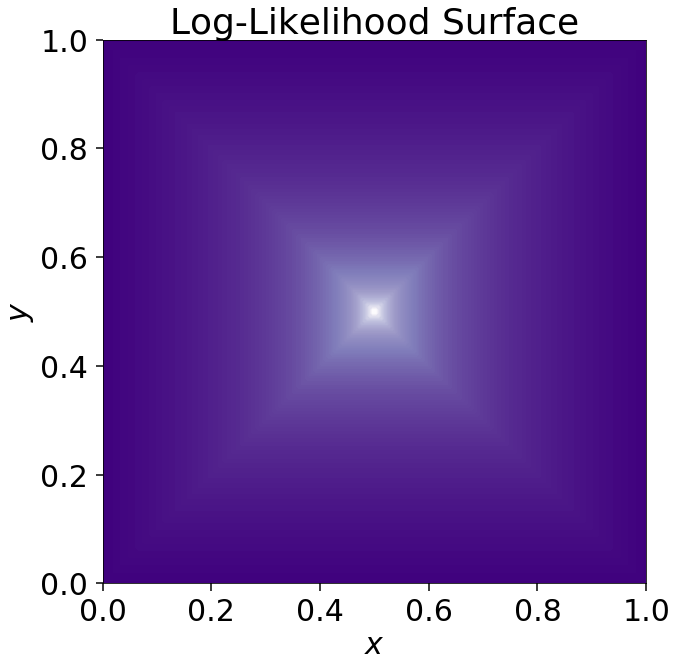

In [4]:
# define the eggbox log-likelihood
s, sigma = 100., 1.
def loglike(x):
    return -max(abs((x - 0.5) / sigma))**(1. / s)

# define the prior transform
def prior_transform(x):
    return x

# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 200),
                     np.linspace(0., 1., 200))
L = np.array([loglike(np.array([x, y]))
              for x, y in zip(xx.flatten(), yy.flatten())])
L = L.reshape(xx.shape)
axes.contourf(xx, yy, L, 200, cmap=plt.cm.Purples_r)
plt.title('Log-Likelihood Surface')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

We will now sample from this distribution using `'multi'`.

In [5]:
ndim = 2
nlive = 1000
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim, 
                                first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                bound='multi', sample='unif', nlive=nlive)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 11 | nc: 1 | ncall: 7414 | eff(%): 47.221 | logz: -1.020 +/-  0.006 | dlogz:  0.032 >  0.010     


Let's now compare the set of samples with the expected theoretical shrinkage. The contours for the bounding volume
are given directly $\mathcal{L}$ since $x_i = [r_0 − 1/2, r_0 + 1/2]$, where 

$$ r_0 = (- \ln \mathcal{L})^s = \sup_i \left| \frac{x_i - \frac{1}{2}}{\sigma_i} \right| $$

The corresponding volume is a hyper-rectangle (N-cube) with

$$ V = (2 \cdot r_0)^d \times \prod_i \sigma_i = (2 \cdot r_0)^d \quad .$$

The PDF of the shrinkage $t$ is

$$ P(t \,|\, K) = (1-t)^{K-1} $$

which has a CDF of 

$$ P(t < T \,|\, K) = t^K \quad . $$

Following Buchner (2014), we can define the quantity

$$ s = 1 - t^{1/d} $$

that represents the side being "sliced" away. This now has a cumulative distribution of

$$ P(s < S) = 1 - (1 - S)^{dN} $$

which is a bit easier to visualize.

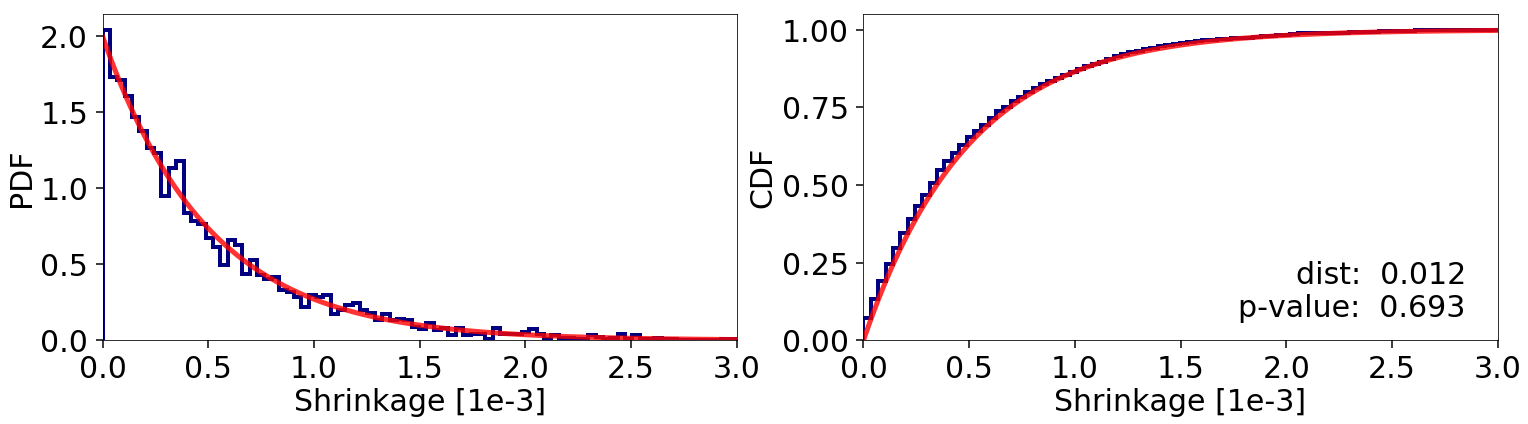

In [6]:
from scipy.stats import kstest

vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# define our PDF/CDF
def pdf(s):
    return ndim * nlive * (1. - s)**(ndim * nlive - 1.)
def cdf(s):
    return 1. - (1. - s)**(ndim * nlive)

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# plot results
xgrid = np.linspace(0., 0.01, 10000)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(25, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', color='navy', normed=True, lw=4)
ax.plot(xgrid * 1e3, pdfgrid / 1e3, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3])
ax.set_ylabel('PDF')

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', cumulative=True, color='navy', normed=True, lw=4)
ax.plot(xgrid * 1e3, cdfgrid, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes);

Now let's turn bootstrapping off.

In [7]:
ndim = 2
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='unif', nlive=nlive,
                                first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                bootstrap=0)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 13 | nc: 1 | ncall: 8294 | eff(%): 42.211 | logz: -1.020 +/-  0.006 | dlogz:  0.032 >  0.010     


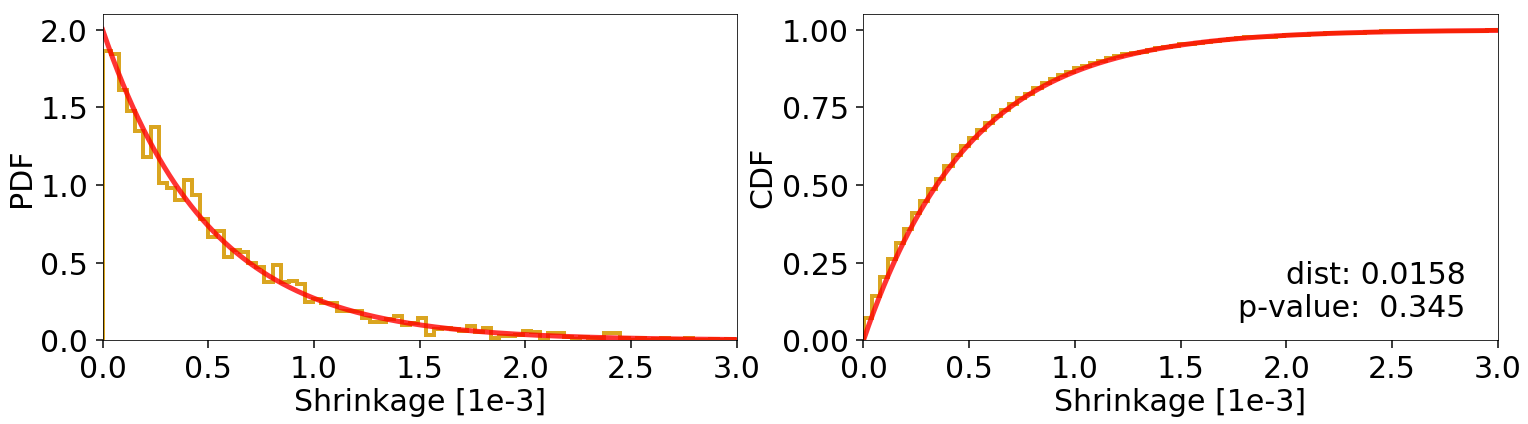

In [8]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(25, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', color='goldenrod', normed=True, lw=4)
ax.plot(xgrid * 1e3, pdfgrid / 1e3, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3])
ax.set_ylabel('PDF')

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', cumulative=True, color='goldenrod', normed=True, lw=4)
ax.plot(xgrid * 1e3, cdfgrid, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 3])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes);

So far so good. But what happens if we increase the number of dimensions?

In [9]:
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='unif', nlive=nlive, 
                                first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                bootstrap=20)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 42 | nc: 9 | ncall: 26613 | eff(%): 13.155 | logz: -1.023 +/-  0.006 | dlogz:  0.031 >  0.010      


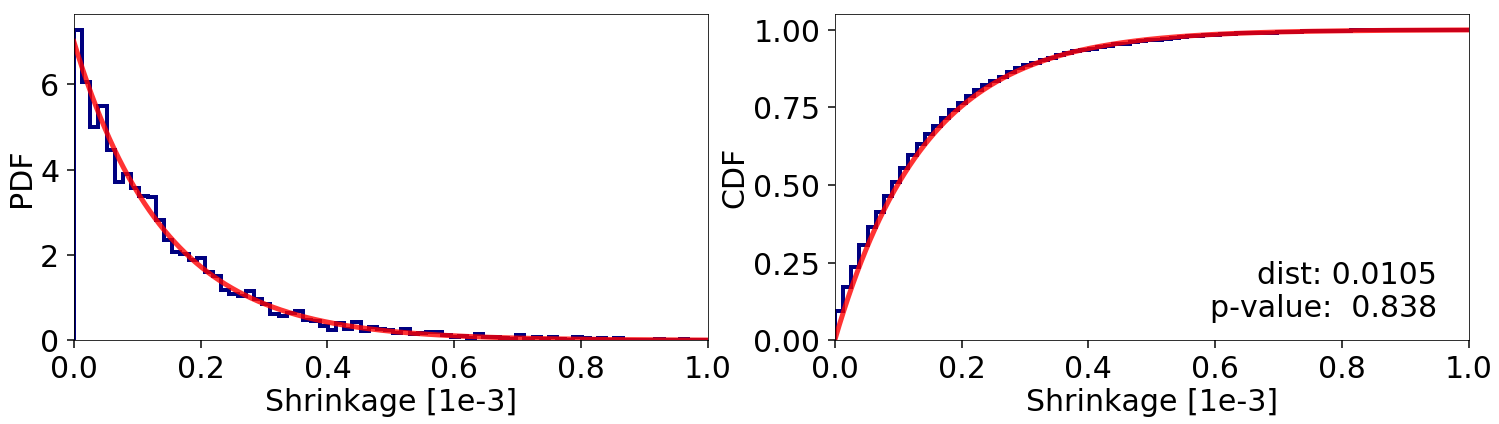

In [10]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(25, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', color='navy', normed=True, lw=4)
ax.plot(xgrid * 1e3, pdfgrid / 1e3, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1])
ax.set_ylabel('PDF')

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', cumulative=True, color='navy', normed=True, lw=4)
ax.plot(xgrid * 1e3, cdfgrid, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes);

In [11]:
ndim = 7
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim=ndim,
                                bound='multi', sample='unif', nlive=nlive, 
                                first_update={'min_ncall': -np.inf, 'min_eff': np.inf},
                                bootstrap=0)
sampler.run_nested(dlogz=0.01, maxiter=3500, add_live=False)
res = sampler.results

iter: 3501 | bound: 21 | nc: 9 | ncall: 13664 | eff(%): 25.622 | logz: -1.023 +/-  0.006 | dlogz:  0.031 >  0.010     


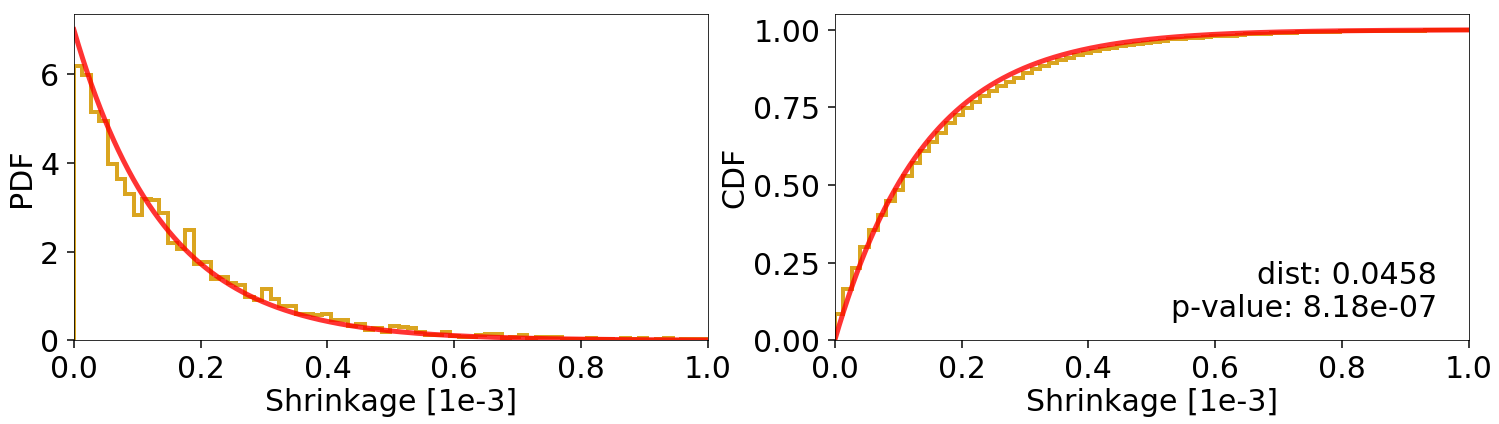

In [12]:
vol = (2 * (-res['logl'])**s)**ndim  # real volumes
t = vol[1:] / vol[:-1]  # shrinkage
S = 1 - t**(1. / ndim)  # slice

# check whether the two distributions are consistent
k_dist, k_pval = kstest(S, cdf)

# PDF
fig, axes = plt.subplots(1, 2, figsize=(25, 6))
ax = axes[0]
pdfgrid = pdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', color='goldenrod', normed=True, lw=4)
ax.plot(xgrid * 1e3, pdfgrid / 1e3, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1])
ax.set_ylabel('PDF')

# CDF
ax = axes[1]
cdfgrid = cdf(xgrid)
n, b, p = ax.hist(S * 1e3, bins=100, histtype='step', cumulative=True, color='goldenrod', normed=True, lw=4)
ax.plot(xgrid * 1e3, cdfgrid, color='red', alpha=0.8, lw=5)
ax.set_xlabel('Shrinkage [1e-3]')
ax.set_xlim([0., 1])
ax.set_ylabel('CDF')
ax.text(0.95, 0.2, 'dist: {:6.3}'.format(k_dist), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes)
ax.text(0.95, 0.1, 'p-value: {:6.3}'.format(k_pval), 
        horizontalalignment='right', verticalalignment='center',
        transform=ax.transAxes);

We see that without incorporating the bootstrap expansion factors our ellipsoids have a tendency to over-constrain the remaining prior volume and shrink too quickly as we move to higher dimensions.